# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
# Import libraries
import os
from time import time
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt                        
%matplotlib inline
import seaborn as sns
sns.set_style('white')
              
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F

# the following import is required for training to be robust to truncated images
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

#from tqdm.notebook import tqdm
from tqdm import tqdm

# check if CUDA is available
use_cuda = torch.cuda.is_available()
if use_cuda:
    print('Cuda is available')

Cuda is available


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# Done: Define your transforms for the training, validation, and testing sets
# Setup the normalizer
normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

# Transforming the data and applying image augmentation for training dataset
train_transform = transforms.Compose([transforms.Resize((224, 224)), # Resize the image to 256x256
                                      transforms.RandomRotation(30), # Randomly rotate the image in the range of 30 degree
                                      transforms.RandomHorizontalFlip(), # Randomly flip the image horizontally
                                      transforms.ToTensor(), # Convert the numpy array that contains the image into a tensor
                                      normalizer]) # Apply the normalizer

# Transformation for test and validation datasets
val_test_transform = transforms.Compose([transforms.Resize((224, 224)), # # Resize the image to 256x256
                                         transforms.ToTensor(), # Convert the numpy array that contains the image into a tensor
                                         normalizer]) # Apply the normalizer

# Done: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=val_test_transform)
test_data = datasets.ImageFolder(test_dir, transform=val_test_transform)

# Done: Using the image datasets and the trainforms, define the dataloaders
# define dataloader parameters
batch_size = 64
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                           num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers)

dataloaders = {'train': train_loader,
               'valid': valid_loader, 
               'test': test_loader}

# print out some data stats
print(f'Number of training images: {len(train_data)}')
print(f'Number of validation images: {len(valid_data)}')
print(f'Number of test images: {len(test_data)}')

Number of training images: 6552
Number of validation images: 818
Number of test images: 819


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [ ]:
# Done: Build and train your network

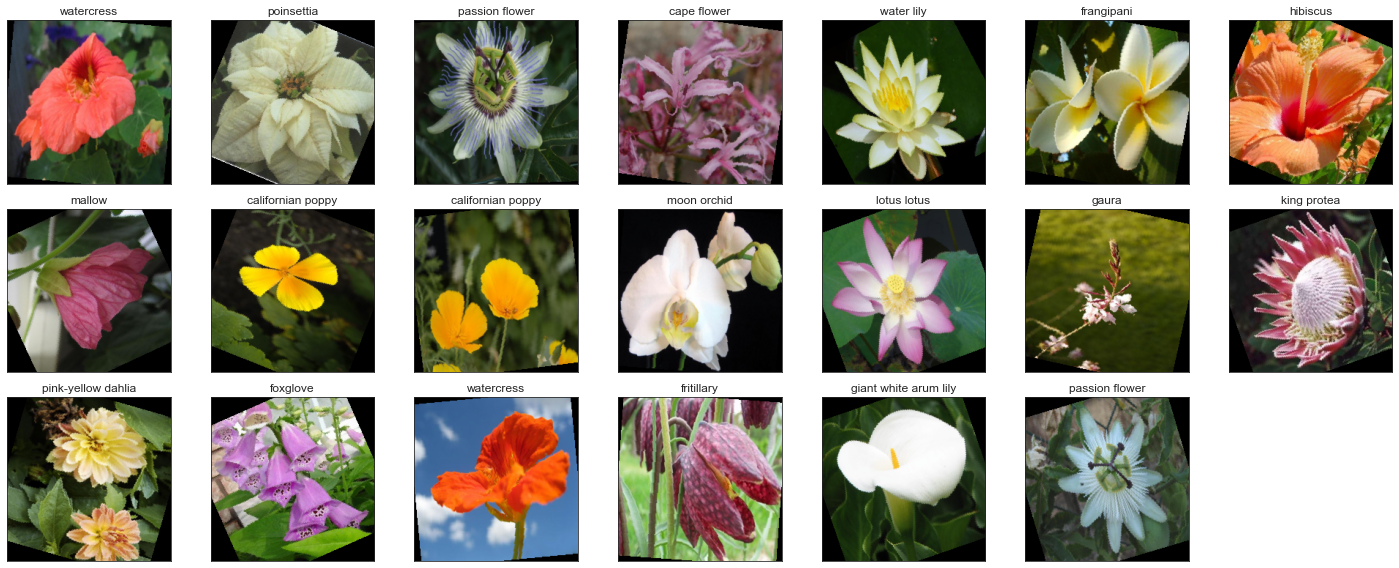

In [11]:
# Get the class names for plotting
class_names = [cat_to_name[item] for item in train_data.classes]
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Plot a batch of preprocessed images
fig, axis = plt.subplots(figsize=(20, 8), nrows=3, ncols=7, tight_layout=True)
axis = axis.flatten()
i = 0
for ax, label in zip(axis, classes): 
    image = inputs[i].to("cpu").clone().detach() # Colne the input tensor and move it to cpu
    image = image.numpy().squeeze() # Convert tensot to numpy array and squeez the 1st dimintion 
    image = image.transpose(1, 2, 0) # Reshape the image array to (height, width, channels)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406)) # Retain the colors again
    image = image.clip(0, 1) # Clip the image values between 0 and 1 
    
    # Display the images
    ax.imshow(image)
    ax.set_title(class_names[label])
    ax.set_xticks([]); ax.set_yticks([])
    i+=1

# Delete the last axis in the figure
fig.delaxes(axis[20]);

In [13]:
# define VGG16 model
model = models.vgg16(pretrained=True)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
# Change the numper of output features for the final layer to the number of classes
model.classifier[6] = nn.Linear(4096, len(cat_to_name))                        
# Freeze training for all "features" layers
for param in model.features.parameters():
    param.requires_grad = False
    
# check if CUDA is available
use_cuda = torch.cuda.is_available()
    
# move model to GPU if CUDA is available
if use_cuda:
    model = model.cuda()
    
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
for p in model.parameters():
    if p.requires_grad:
         print(p.name, p.data.shape)

None torch.Size([4096, 25088])
None torch.Size([4096])
None torch.Size([4096, 4096])
None torch.Size([4096])
None torch.Size([102, 4096])
None torch.Size([102])


In [17]:
dict_c = {}
for dir in os.listdir('flowers/train'):
    class_num = dir
    img_count = len(os.listdir('flowers/train/' + dir))
    dict_c[int(class_num)] = img_count
    

In [18]:
num_train_classes = pd.DataFrame.from_dict(dict_c, orient='index').reset_index()
num_train_classes.columns = ['class', 'counts']
num_train_classes = num_train_classes.sort_values('class').reset_index()

In [19]:
# Weight tensor for CrossEntropyLoss
weight = torch.FloatTensor(1/num_train_classes['counts']).cuda()
weight

tensor([0.0370, 0.0204, 0.0278, 0.0227, 0.0185, 0.0286, 0.0303, 0.0143, 0.0244,
        0.0263, 0.0147, 0.0137, 0.0263, 0.0227, 0.0263, 0.0278, 0.0167, 0.0154,
        0.0263, 0.0217, 0.0294, 0.0213, 0.0139, 0.0286, 0.0294, 0.0303, 0.0278,
        0.0182, 0.0161, 0.0164, 0.0208, 0.0278, 0.0323, 0.0357, 0.0303, 0.0161,
        0.0109, 0.0227, 0.0303, 0.0185, 0.0103, 0.0204, 0.0100, 0.0137, 0.0303,
        0.0064, 0.0164, 0.0175, 0.0263, 0.0137, 0.0049, 0.0149, 0.0143, 0.0213,
        0.0179, 0.0109, 0.0200, 0.0116, 0.0179, 0.0118, 0.0278, 0.0208, 0.0238,
        0.0238, 0.0114, 0.0196, 0.0278, 0.0233, 0.0217, 0.0196, 0.0156, 0.0130,
        0.0068, 0.0070, 0.0105, 0.0120, 0.0049, 0.0089, 0.0294, 0.0122, 0.0074,
        0.0122, 0.0096, 0.0152, 0.0208, 0.0208, 0.0196, 0.0086, 0.0065, 0.0152,
        0.0169, 0.0189, 0.0294, 0.0076, 0.0099, 0.0139, 0.0185, 0.0147, 0.0200,
        0.0286, 0.0204, 0.0278], device='cuda:0')

In [24]:
criterion = nn.CrossEntropyLoss(weight=weight)
optimizer = optim.SGD(model.classifier.parameters(), lr= 0.01)

In [25]:
# Train function
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, model_path, summary_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    # Initialize empty lists to track training and validation losses and accuracy for each epoch
    train_losses = []
    valid_losses = []
    train_acc = []
    valid_acc = []
    # Start time to calculate the time for training
    train_start = time()
    for epoch in range(1, n_epochs+1):
        with tqdm(total = len(train_data)) as t_epoch_pbar:
            t_epoch_pbar.set_description(f'Epoch {epoch}/{n_epochs}')
            # Start time for epoch
            epoch_start = time()
            # initialize variables to monitor training and validation loss
            train_loss = 0.0
            valid_loss = 0.0
            train_correct = 0.0
            train_total = 0.0
            valid_correct = 0.0
            valid_total = 0.0
            ###################
            # train the model #
            ###################
            model.train()
            for batch_idx, (data, target) in enumerate(loaders['train']):
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                ## find the loss and update the model parameters accordingly
                # clear the gradients of all optimized variables
                optimizer.zero_grad()
                # forward pass
                output = model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # backward pass
                loss.backward()
                # perform a single optimization step to update model parameters
                optimizer.step()
                # update training loss 
                train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
                # convert output probabilities to predicted class
                pred = output.data.max(1, keepdim=True)[1]
                # compare predictions to true label
                train_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
                train_total += data.size(0)
                # Update the progress bar
                desc = f'Epoch: {epoch}/{n_epochs} - Train loss = {train_loss:.4f} - Train Accuracy = {train_correct/train_total:.2%}'
                t_epoch_pbar.set_description(desc)
                t_epoch_pbar.update(data.shape[0])
            ######################    
            # validate the model #
            ######################
            model.eval()
        with tqdm(total = len(valid_data)) as v_epoch_pbar:
            v_epoch_pbar.set_description(f'Epoch {epoch}/{n_epochs}')
            for batch_idx, (data, target) in enumerate(loaders['valid']):
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                ## update the average validation loss
                # forward pass
                output = model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # update average validation loss 
                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
                # convert output probabilities to predicted class
                pred = output.data.max(1, keepdim=True)[1]
                # compare predictions to true label
                valid_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
                valid_total += data.size(0)
                # Update the progress bar
                desc = f'Epoch: {epoch}/{n_epochs} - Valid loss = {valid_loss:.4f} - Valid Accuracy = {valid_correct/(valid_total+1e-10):.2%}'
                v_epoch_pbar.set_description(desc)
                v_epoch_pbar.update(data.shape[0])


        # Add train and valid loss for each epoch to the train_losses and valid_losses lists
        train_losses.append(train_loss.cpu().numpy())
        valid_losses.append(valid_loss.cpu().numpy())
        train_acc.append(100. * train_correct / train_total)
        valid_acc.append(100. * valid_correct / valid_total)
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving the model ...')
            torch.save(model.state_dict(), model_path)
            valid_loss_min = valid_loss
    
    # Save Model Summary to a pandas DF
    print('Saving the model summary ...')
    summary_dict = {
        'epoch': np.arange(1, n_epochs+1, 1),
        'train_losses': train_losses,
        'valid_losses': valid_losses,
        'train_acc': train_acc,
        'valid_acc': valid_acc,
    }
    model_summary = pd.DataFrame(summary_dict)
    # Save the df to csv file
    model_summary.to_csv(summary_path, index=False)
    print(f'Finished Training in: {time()-train_start:.0f} Seconds')
    # return trained model and the model_summary dataframe
    return model, model_summary

In [27]:
# train the model

model, model_summary = train(10, dataloaders, model, optimizer, 
                                     criterion, use_cuda, 'models/model.pt', 'models/model_summary.csv')

Epoch: 1/10 - Train loss = 1.8883 - Train Accuracy = 48.12%: 100%|█| 6552/6552 
Epoch: 1/10 - Valid loss = 1.4449 - Valid Accuracy = 61.25%: 100%|█| 818/818 [0


Validation loss decreased (inf --> 1.444900).  Saving the model ...


Epoch: 2/10 - Train loss = 1.3231 - Train Accuracy = 61.32%: 100%|█| 6552/6552 
Epoch: 2/10 - Valid loss = 1.1085 - Valid Accuracy = 68.83%: 100%|█| 818/818 [0


Validation loss decreased (1.444900 --> 1.108496).  Saving the model ...


Epoch: 3/10 - Train loss = 1.0334 - Train Accuracy = 69.03%: 100%|█| 6552/6552 
Epoch: 3/10 - Valid loss = 0.8545 - Valid Accuracy = 75.31%: 100%|█| 818/818 [0


Validation loss decreased (1.108496 --> 0.854488).  Saving the model ...


Epoch: 4/10 - Train loss = 0.8988 - Train Accuracy = 72.71%: 100%|█| 6552/6552 
Epoch: 4/10 - Valid loss = 0.8618 - Valid Accuracy = 73.23%: 100%|█| 818/818 [0
Epoch: 5/10 - Train loss = 0.7754 - Train Accuracy = 75.72%: 100%|█| 6552/6552 
Epoch: 5/10 - Valid loss = 0.7129 - Valid Accuracy = 78.61%: 100%|█| 818/818 [0


Validation loss decreased (0.854488 --> 0.712892).  Saving the model ...


Epoch: 6/10 - Train loss = 0.6836 - Train Accuracy = 78.33%: 100%|█| 6552/6552 
Epoch: 6/10 - Valid loss = 0.6493 - Valid Accuracy = 80.56%: 100%|█| 818/818 [0


Validation loss decreased (0.712892 --> 0.649288).  Saving the model ...


Epoch: 7/10 - Train loss = 0.6176 - Train Accuracy = 80.53%: 100%|█| 6552/6552 
Epoch: 7/10 - Valid loss = 0.6487 - Valid Accuracy = 80.56%: 100%|█| 818/818 [0


Validation loss decreased (0.649288 --> 0.648748).  Saving the model ...


Epoch: 8/10 - Train loss = 0.5701 - Train Accuracy = 81.58%: 100%|█| 6552/6552 
Epoch: 8/10 - Valid loss = 0.5998 - Valid Accuracy = 79.71%: 100%|█| 818/818 [0


Validation loss decreased (0.648748 --> 0.599837).  Saving the model ...


Epoch: 9/10 - Train loss = 0.5279 - Train Accuracy = 82.63%: 100%|█| 6552/6552 
Epoch: 9/10 - Valid loss = 0.5408 - Valid Accuracy = 83.37%: 100%|█| 818/818 [0


Validation loss decreased (0.599837 --> 0.540840).  Saving the model ...


Epoch: 10/10 - Train loss = 0.4914 - Train Accuracy = 83.70%: 100%|█| 6552/6552
Epoch: 10/10 - Valid loss = 0.5454 - Valid Accuracy = 83.01%: 100%|█| 818/818 [

Saving the model summary ...
Finished Training in: 758 Seconds


In [28]:
# Helper function to plot the model summary

def plot_model_summary(model_summary):
    fig, ax = plt.subplots(figsize=(20, 6), ncols=2)
    ax[0].plot(model_summary.train_losses, color='#40e580')
    ax[0].plot(model_summary.valid_losses, color='#00334e')
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    #ax[0].spines['left'].set_visible(False)
    ax[0].set_title('Training VS Validation Loss', fontdict={'fontsize': 20, 'fontweight':'bold'})
    ax[0].set_xlabel('Epoch', fontdict={'fontsize': 14})
    ax[0].set_ylabel('Loss', fontdict={'fontsize': 14})
    ax[0].set_ylim(0)
    ax[0].legend(['Training', 'Validation']);

    ax[1].plot(model_summary.train_acc, color='#40e580')
    ax[1].plot(model_summary.valid_acc, color='#00334e')
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    #ax[1].spines['left'].set_visible(False)
    ax[1].set_title('Training VS Validation Accuracy', fontdict={'fontsize': 20, 'fontweight':'bold'})
    ax[1].set_xlabel('Epoch', fontdict={'fontsize': 14})
    ax[1].set_ylabel('Accuracy', fontdict={'fontsize': 14})
    ax[1].set_ylim(0)
    ax[1].legend(['Training', 'Validation']);

In [29]:
model_summary = pd.read_csv('models/model_summary.csv')

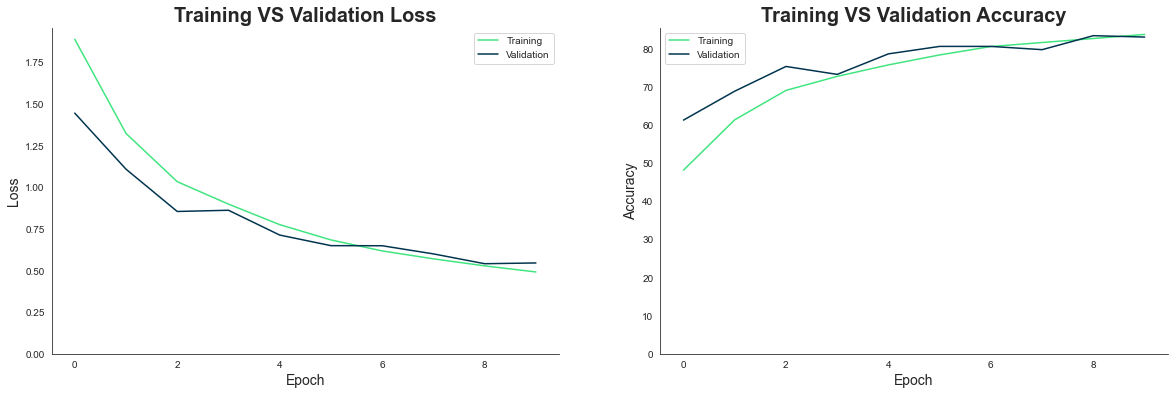

In [30]:
# Plot model  summary
plot_model_summary(model_summary)

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [31]:
# Done: Do validation on the test set

In [32]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


In [33]:
test(dataloaders, model, criterion, use_cuda)

Test Loss: 0.641952


Test Accuracy: 81% (671/819)


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [34]:
# Done: Save the checkpoint 

In [37]:
# Attach class to index to the model
model.class_to_idx =  train_data.class_to_idx

# Checkpoint file path
checkpoint_file = 'checkpoint.pth'
# model state dict
model_state = {
    'state_dict': model.state_dict(),
    'optimizer_dict': optimizer.state_dict(),
    'classifier': model.classifier,
    'class_to_idx': model.class_to_idx,
    'classes_weights': weight
}
# Save the model
torch.save(model_state, checkpoint_file)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [38]:
# Done: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(checkpoint_file='checkpoint.pth'):
    # Load model state
    model_state = torch.load(checkpoint_file)
    
    # Build the model
    model = models.vgg16(pretrained=True)
    model.classifier = model_state['classifier']
    model.load_state_dict(model_state['state_dict'])
    model.class_to_idx = model_state['class_to_idx']

    return model

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [45]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Done: Process a PIL image for use in a PyTorch model
    # First load the image
    img = Image.open(image)
    
    # Setup the normalizer
    normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])
    
    # Setting up image preprocessor
    img_transform = transforms.Compose([transforms.Resize((224, 224)), # Resize the image to 244x244
                                        transforms.ToTensor(), # Convert the numpy array that contains the image into a tensor
                                        normalizer]) # Apply the normalizer
    
    # Apply the preprocessing to the image 
    # And add a dummy axis as the model expect a batch of images not a single image
    preproccessed_img = img_transform(img)
    
    return preproccessed_img

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [46]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

<AxesSubplot:>

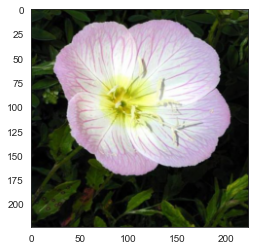

In [47]:
test_image = process_image('flowers/test/1/image_06743.jpg')
imshow(test_image)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [97]:
preproccessed_img = process_image('flowers/test/1/image_06743.jpg')
preproccessed_img = preproccessed_img.unsqueeze(0)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move imag to GPU if CUDA is available
if use_cuda:
    preproccessed_img = preproccessed_img.cuda()

# Use VGG16 to predict the class of the image
model.eval()
pred = F.softmax(model.forward(preproccessed_img), dim=1)
prob, ind = pred.topk(5)
prob = np.squeeze(prob.cpu().detach().numpy())
inx = np.squeeze(ind.cpu().detach().numpy())
print(prob)
print(inx)

[0.8606435  0.09862514 0.00908123 0.00716391 0.00638033]
[ 0 76 84 87 49]


In [100]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # DONE: Implement the code to predict the class from an image file
    # Preprocess the image before passing it to the model
    preproccessed_img = process_image(image_path)
    preproccessed_img = preproccessed_img.unsqueeze(0)

    # check if CUDA is available
    use_cuda = torch.cuda.is_available()

    # move imag to GPU if CUDA is available
    if use_cuda:
        preproccessed_img = preproccessed_img.cuda()

    # Use VGG16 to predict the class of the image
    model.eval()
    pred = F.softmax(model.forward(preproccessed_img), dim=1)
    prob, idx = pred.topk(5)
    prob = np.squeeze(prob.cpu().detach().numpy())
    idx = np.squeeze(idx.cpu().detach().numpy())
    
    # Dictionary to map the indices to their class numbers
    idx_to_class = {model.class_to_idx[i]: i for i in model.class_to_idx}
    
    # Getting the class names for the top k predictions
    classes = [idx_to_class[i] for i in idx]
    
    return prob, classes

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [102]:
# Done: Display an image along with the top 5 classes

In [133]:
test_images_paths = np.array(glob("flowers/test/*/*"))
random_images = np.random.randint(0, test_images_paths.shape[0], (5))
test_images = test_images_paths[random_images]
test_labels = [test_images[i].split('\\')[1] for i in range(test_images.shape[0])]

In [134]:
print(test_images)
print(test_labels)

['flowers/test\\94\\image_07400.jpg' 'flowers/test\\19\\image_06159.jpg'
 'flowers/test\\78\\image_01928.jpg' 'flowers/test\\85\\image_04786.jpg'
 'flowers/test\\85\\image_04801.jpg']
['94', '19', '78', '85', '85']


In [145]:
def plot_predictions(test_images, test_labels, model, topk=5):
    """Function to plot the predictions and the top k predicted classes.
       param: test_images: test images to plot
       param: test_labels: true labels
       param: model: the model to use for predictions
       param: topk: the number of top predicted classes to return
    """
    # Show the images and a bar chart with the predictions probabilty
    fig, axes = plt.subplots(test_images.shape[0], 2, figsize=(16, 12))
    fig.subplots_adjust(hspace=0.4, wspace=-0.2)

    for i, (image, label) in enumerate(zip(test_images, test_labels)):
        prob, predicted_labels = predict(image, model, topk=5)
        predicted_label = predicted_labels[np.argmax(prob)]
        image_title = f"Label: {label}, Pred: [{predicted_label}]"
        axes[i, 0].imshow(Image.open(image))
        axes[i, 0].get_xaxis().set_visible(False)
        axes[i, 0].get_yaxis().set_visible(False)
        if label == predicted_label:
            axes[i, 0].set_title(image_title, color='g')
        else:
            axes[i, 0].set_title(image_title, color='r')
        predicted_classes = [cat_to_name[i] for i in predicted_labels]
        axes[i, 1].bar(predicted_classes, prob)
        axes[i, 1].set_title(f"Top {topk} predicted classes")

    plt.show()
    

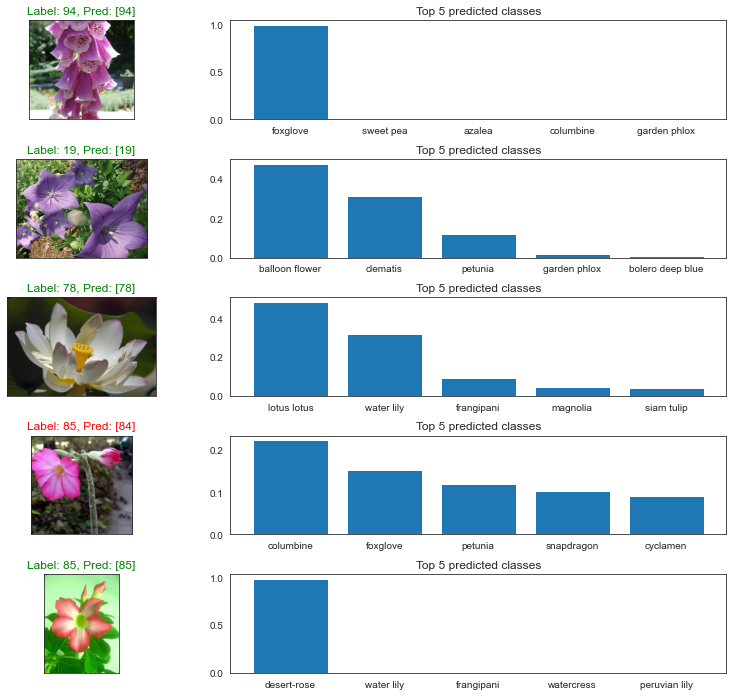

In [146]:
plot_predictions(test_images, test_labels, model, topk=5)